In [1]:
import warnings
warnings.filterwarnings('ignore')

### 1. 데이터 EDA

- 해당 dataset에는 30개의 조업변수(x1~x30)와 5개의 관리변수(A~D)가 시계열 흐름에 따라 구성되어 있습니다.
- 관리변수의 상승/하락에 따라 전기 분해 과정에서 품질 및 생산성, 원가가 결정됩니다.
- 그렇기에 조업변수 및 시계열 흐름과 관리변수에 대한 영향을 중점으로 분석합니다.
- 추가로, 관리 변수 중 상승/하락에 따른 생산성 등에 대한 영향이 반대인 경우가 있으니 이를 구분하여 줍니다.

In [2]:
import pandas as pd

# 훈련 데이터 로드
path = 'dataset/train.csv'
train_df = pd.read_csv(path)
train_df.head()

,Getting_Time,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X26,X27,X28,X29,X30,A,B,C,D,E
0,2022-11-25 06:15:00,3.999053,2.904105,0.512421,17.256421,11.969895,9.808474,17.270632,11.782316,9.716105,...,0.085053,0.080737,0.020842,0.044421,0.066474,533.740825,56.166584,30.795462,0.063058,0.032226
1,2022-11-25 06:16:00,3.997158,2.904789,0.496368,17.296263,11.962579,9.812632,17.274737,11.792474,9.713211,...,0.088000,0.080316,0.019947,0.048158,0.066316,533.704004,56.165217,30.695193,0.063065,0.032231
2,2022-11-25 06:17:00,3.996947,2.906474,0.489158,17.300737,11.971579,9.801684,17.277105,11.788526,9.715632,...,0.085421,0.081684,0.019263,0.046579,0.067526,533.667183,56.163850,30.687938,0.063071,0.032236
3,2022-11-25 06:18:00,3.995895,2.904105,0.483526,17.274789,11.960579,9.818579,17.250158,11.795211,9.721105,...,0.083263,0.082316,0.018000,0.043684,0.067316,533.630362,56.162483,30.703927,0.063078,0.032241
4,2022-11-25 06:19:00,3.994316,2.901000,0.504579,17.267421,11.971684,9.815421,17.277000,11.790158,9.730263,...,0.085474,0.081368,0.018316,0.046368,0.066263,533.593541,56.161116,30.756081,0.063085,0.032246


- Geting_Time을 시간, 요일, 날짜, 월로 나누어 추가 변수를 만듭니다.
- 해당 변수에 따른 관리변수와의 상관성이 존재할 가능성이 있습니다.

In [3]:
#  'Geting_Time'을 날짜 시간으로 변환
train_df['Getting_Time'] = pd.to_datetime(train_df['Getting_Time'])

# 시간 특징들 추출
train_df['Hour'] = train_df['Getting_Time'].dt.hour
train_df['DayOfWeek'] = train_df['Getting_Time'].dt.dayofweek
train_df['Day'] = train_df['Getting_Time'].dt.day
train_df['Month'] = train_df['Getting_Time'].dt.month

In [4]:
# 변수들의 상관관계 분석
corr = train_df.corr()
corr.head()

,Getting_Time,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X30,A,B,C,D,E,Hour,DayOfWeek,Day,Month
Getting_Time,1.000000,-0.050103,-0.870148,0.935925,-0.873445,-0.353408,0.523254,-0.813059,-0.928555,0.557648,...,-0.953526,0.470127,0.418990,0.842523,-0.548788,0.971381,-0.017379,0.036590,0.043983,-0.961311
X1,-0.050103,1.000000,0.043751,-0.020759,0.000627,-0.049235,-0.004491,0.003257,0.030636,-0.030653,...,0.017725,-0.053738,-0.047674,-0.063708,0.017206,-0.043084,0.015493,-0.012257,-0.047649,0.058441
X2,-0.870148,0.043751,1.000000,-0.786730,0.726105,0.279214,-0.408647,0.697447,0.817787,-0.420866,...,0.832406,-0.353067,-0.226799,-0.682950,0.416194,-0.901366,0.011678,-0.102229,0.071090,0.820588
X3,0.935925,-0.020759,-0.786730,1.000000,-0.878026,-0.296166,0.660735,-0.821814,-0.922677,0.690217,...,-0.943817,0.540661,0.522756,0.874843,-0.668688,0.879575,-0.023016,0.027482,-0.039766,-0.914043
X4,-0.873445,0.000627,0.726105,-0.878026,1.000000,0.318394,-0.508024,0.755922,0.861859,-0.546027,...,0.929475,-0.531023,-0.422803,-0.826918,0.662422,-0.869592,0.043776,-0.082391,-0.064825,0.871158


In [5]:
# 전체 변수의 상관관계 확인해보기

# 상관관계 임계값 설정
corr_threshold = 0.95

# 임계값 이상의 상관 관계를 가진 특징 쌍 찾기
high_corr_set = []
for feature_1 in corr.columns:
    for feature_2 in corr.columns:
        # 중복을 방지하려면 other_feature가 feature보다 큰지만 확인합니다(행렬이 대칭이므로)
        if feature_2 > feature_1 and abs(corr.at[feature_1, feature_2]) > corr_threshold:
            high_corr_set.append((feature_1, feature_2, corr.at[feature_1, feature_2]))

len(high_corr_set)

32

- 위 결과 상관관계가 0.95이상인 변수들의 쌍이 상당히 많다는 것을 알 수 있습니다.
- 이는 충분히 ****다중공선성****이 우려될 수 있는 상황이므로, 상관관계가 너무 강한 변수 쌍들 중 일부를 어느 정도 줄여줄 필요가 있습니다.

In [6]:
# 지우면 안되는 주요 변수들
important_features = ['A', 'B', 'C', 'D', 'E', 'Getting_Time']

# 주요 특징을 제외한 상관계수 0.95 이상인 특징 쌍 추출
high_corr = [pair for pair in high_corr_set if pair[0] not in important_features and pair[1] not in important_features]

# 제거할 특징 결정
# 이 경우, 각 쌍에서 첫 번째 특징을 제거하는 것으로 결정
features_to_remove = set(pair[0] for pair in high_corr)

# 제거할 특징 목록
features_to_remove

{'Month', 'X11', 'X12', 'X13', 'X15', 'X16', 'X20', 'X22', 'X25'}

In [7]:
# 제거할 특징을 데이터셋에서 제거
train_df = train_df.drop(columns=list(features_to_remove))

# 업데이트된 데이터프레임의 첫 5행을 확인
train_df.head()

,Getting_Time,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X29,X30,A,B,C,D,E,Hour,DayOfWeek,Day
0,2022-11-25 06:15:00,3.999053,2.904105,0.512421,17.256421,11.969895,9.808474,17.270632,11.782316,9.716105,...,0.044421,0.066474,533.740825,56.166584,30.795462,0.063058,0.032226,6,4,25
1,2022-11-25 06:16:00,3.997158,2.904789,0.496368,17.296263,11.962579,9.812632,17.274737,11.792474,9.713211,...,0.048158,0.066316,533.704004,56.165217,30.695193,0.063065,0.032231,6,4,25
2,2022-11-25 06:17:00,3.996947,2.906474,0.489158,17.300737,11.971579,9.801684,17.277105,11.788526,9.715632,...,0.046579,0.067526,533.667183,56.163850,30.687938,0.063071,0.032236,6,4,25
3,2022-11-25 06:18:00,3.995895,2.904105,0.483526,17.274789,11.960579,9.818579,17.250158,11.795211,9.721105,...,0.043684,0.067316,533.630362,56.162483,30.703927,0.063078,0.032241,6,4,25
4,2022-11-25 06:19:00,3.994316,2.901000,0.504579,17.267421,11.971684,9.815421,17.277000,11.790158,9.730263,...,0.046368,0.066263,533.593541,56.161116,30.756081,0.063085,0.032246,6,4,25


- 관리변수인 A, B, C, D, E 중에서 영향을 많이 미치는 순서를 파악해봅니다.
- 표준편차를 기준으로 파악해보겠습니다. 변동이 심한 값을 수일 큰 영향을 끼치는 변수일 확률이 높습니다.

In [8]:
# 데이터세트의 기초 통계량
describe = train_df.describe()

# 'std' 행에서 수치형 데이터만 추출하고 NaN으로 변환할 수 없는 값을 처리
describe = pd.to_numeric(describe.loc['std'], errors='coerce')

# 에너지 소비를 대표할 가능성이 있는 후보 특징 식별
# 표준 편차를 기준으로 가장 큰 변수 순서로 정렬
energy_param = describe.nlargest(20)
energy_param

A            54.249236
Day          10.797770
Hour          6.885412
C             6.440145
B             3.646940
DayOfWeek     1.991945
X4            0.721432
X2            0.346338
X8            0.220845
X7            0.159528
X3            0.157189
X10           0.079197
X9            0.064377
X6            0.054030
X5            0.049041
X27           0.046731
X30           0.029516
X18           0.028348
X19           0.019247
X21           0.019241
Name: std, dtype: float64

- 관리변수 중 A가 가장 압도적으로 높고, C, B가 그 다음으로 높습니다.
- 이는 추후 관리변수들의 영향도를 분석할 때 변수 별로 가중치를 두는 방향으로 활용할 수 있습니다.

- 다음은 **시계열 데이터**를 고려하여 시간지연 lag데이터를 생성하여 줍니다. 시계열 데이터가 포함되어 있는 이상 필수 고려사항이라고 생각합니다.
- 간격은 6시간/12시간/24시간으로 설정합니다.
- 관리변수와 조업변수간의 영향도 파악이 목적이므로, 조업변수에만 lag데이터를 생성해줍니다.

In [9]:
# Getting_Time'을 인덱스로 설정
train_df.set_index('Getting_Time', inplace=True)

# 여러 시간 간격에 대한 지연 특징 생성 (6시간, 12시간, 24시간)
lag_hours = [6, 12, 24]

# 시간 관련 데이터와 관리변수는 lag를 생성에서 제외
date_features = ['Hour', 'DayOfWeek', 'Day', 'Month', 'A', 'B', 'C', 'D', 'E'] 
date_features = [col for col in date_features if col in train_df.columns]
columns = train_df.drop(columns=date_features).columns 

for feature in columns:
    for lag in lag_hours:
        train_df[f'{feature}_lag_{lag}h'] = train_df[feature].shift(lag)

# 결측치 처리: 지연 특징 생성 후 발생하는 결측치를 제거
train_df.dropna(inplace=True)

train_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X27_lag_24h,X28_lag_6h,X28_lag_12h,X28_lag_24h,X29_lag_6h,X29_lag_12h,X29_lag_24h,X30_lag_6h,X30_lag_12h,X30_lag_24h
Getting_Time,,,,,,,,,,,,,,,,,,,,,
2022-11-25 06:39:00,3.999158,2.898000,0.494211,17.288842,11.976263,9.809947,17.269789,11.801579,9.705000,17.172526,...,0.080737,0.018474,0.020105,0.020842,0.047947,0.045632,0.044421,0.067737,0.069474,0.066474
2022-11-25 06:40:00,4.000000,2.898895,0.496263,17.294316,11.959684,9.788895,17.253789,11.802105,9.717895,17.162947,...,0.080316,0.019316,0.018316,0.019947,0.046368,0.046211,0.048158,0.066789,0.068579,0.066316
2022-11-25 06:41:00,4.000211,2.895526,0.493684,17.288316,11.958842,9.808842,17.300368,11.790263,9.722947,17.161421,...,0.081684,0.018895,0.017579,0.019263,0.045421,0.044947,0.046579,0.067158,0.067421,0.067526
2022-11-25 06:42:00,4.000222,2.896389,0.501944,17.267944,11.965500,9.819611,17.297389,11.788444,9.716667,17.167222,...,0.082316,0.019579,0.020842,0.018000,0.048158,0.046211,0.043684,0.067000,0.068000,0.067316
2022-11-25 06:43:00,3.999579,2.895842,0.501737,17.255474,11.963842,9.804316,17.291211,11.813000,9.733105,17.181474,...,0.081368,0.018105,0.019368,0.018316,0.045737,0.047263,0.046368,0.068000,0.069053,0.066263


- 관리변수와 조업변수(lag데이터 포함)간의 상관관계를 분석합니다.
- 각 관리변수 별로 일정 수준 이상의 상관성을 가지는 특징들을 필터링하여 학습 데이터에 포함시킵니다.

In [10]:
# 조업변수(X1 ~ X30) 및 lag데이터와 관리변수(A, B, C, D, E)의 상관관계 추출
abcde = ['A', 'B', 'C', 'D', 'E']
corr = train_df.corr()
abcde_corr = corr[abcde]
abcde_corr = abcde_corr[~abcde_corr.index.isin(abcde)] # 인덱스 중 abcde 제외 (관리변수들간의 상관관계 포함 x)
abcde_corr.head()

,A,B,C,D,E
X1,-0.054040,-0.048089,-0.063852,0.017196,-0.043101
X2,-0.358391,-0.233052,-0.686667,0.416177,-0.902753
X3,0.540888,0.523583,0.875071,-0.669101,0.879592
X4,-0.531059,-0.422802,-0.827005,0.662884,-0.869623
X5,-0.228724,0.126449,-0.239889,-0.205767,-0.378509


- 관리변수 중 A, B, C는 값이 커질수록 비즈니스 효율이 상승하고, D, E는 값이 낮아질수록 비즈니스 효율이 상승합니다.
- 이를 고려하여, 각 관리변수 별 긍정적/부정적인 영향을 주는 관리변수들을 구분해줍니다.

In [11]:
# 상관관계 임계값 설정
abcde_corr_threshold = 0.2

# 각 관리변수별 영향을 미치는 변수 선택
# A,B,C는 높을 수록 에너지 효율이 높고, D,E는 낮을 수록 에너지 효율이 높은 것을 반영
abcde_features = {"A": {"positive": [], "negative": []}, 
                  "B": {"positive": [], "negative": []}, 
                  "C": {"positive": [], "negative": []}, 
                  "D": {"positive": [], "negative": []}, 
                  "E": {"positive": [], "negative": []}}

for var in abcde:
    for var_corr in abcde_corr.index:
        correlation = abcde_corr.at[var_corr, var]
        # A, B, C: 양의 상관관계와 유의한 상관관계가 있는 변수 선택 (높을수록 좋음)
        if var in ['A', 'B', 'C']:
            if correlation >= abcde_corr_threshold: # 0.2보다 크면 (positive)
                abcde_features[var]["positive"].append(var_corr)
            elif correlation <= -abcde_corr_threshold: # -0.보다 작으면 (negative)
                abcde_features[var]["negative"].append(var_corr)
        # D, E: 음의 상관관계와 유의한 상관관계가 있는 변수 선택 (낮을수록 좋음))
        elif var in ['D', 'E']:
            if correlation <= -abcde_corr_threshold: # -0.2보다 작으면 (positive)
                abcde_features[var]["positive"].append(var_corr)
            elif correlation >= abcde_corr_threshold: # 0.2보다 크면 (negative)
                abcde_features[var]["negative"].append(var_corr)

abcde_features

{'A': {'positive': ['X3',
   'X6',
   'X9',
   'X14',
   'X17',
   'X19',
   'X21',
   'X29',
   'X3_lag_6h',
   'X3_lag_12h',
   'X3_lag_24h',
   'X6_lag_6h',
   'X6_lag_12h',
   'X6_lag_24h',
   'X9_lag_6h',
   'X9_lag_12h',
   'X9_lag_24h',
   'X14_lag_6h',
   'X14_lag_12h',
   'X14_lag_24h',
   'X17_lag_6h',
   'X17_lag_12h',
   'X17_lag_24h',
   'X19_lag_6h',
   'X19_lag_12h',
   'X19_lag_24h',
   'X21_lag_6h',
   'X21_lag_12h',
   'X21_lag_24h',
   'X29_lag_6h',
   'X29_lag_12h',
   'X29_lag_24h'],
  'negative': ['X2',
   'X4',
   'X5',
   'X7',
   'X8',
   'X18',
   'X23',
   'X24',
   'X26',
   'X27',
   'X28',
   'X30',
   'X2_lag_6h',
   'X2_lag_12h',
   'X2_lag_24h',
   'X4_lag_6h',
   'X4_lag_12h',
   'X4_lag_24h',
   'X5_lag_6h',
   'X5_lag_12h',
   'X5_lag_24h',
   'X7_lag_6h',
   'X7_lag_12h',
   'X7_lag_24h',
   'X8_lag_6h',
   'X8_lag_12h',
   'X8_lag_24h',
   'X18_lag_6h',
   'X18_lag_12h',
   'X18_lag_24h',
   'X23_lag_6h',
   'X23_lag_12h',
   'X23_lag_24h',
   'X24

In [12]:
# 최종 훈련데이터 생성

# positive
train_df_A_p = train_df[['A'] + abcde_features['A']['positive']]
train_df_B_p = train_df[['B'] + abcde_features['B']['positive']]
train_df_C_p = train_df[['C'] + abcde_features['C']['positive']]
train_df_D_p = train_df[['D'] + abcde_features['D']['positive']]
train_df_E_p = train_df[['E'] + abcde_features['E']['positive']]
# # nagative
train_df_A_n = train_df[['A'] + abcde_features['A']['negative']]
train_df_B_n = train_df[['B'] + abcde_features['B']['negative']]
train_df_C_n = train_df[['C'] + abcde_features['C']['negative']]
train_df_D_n = train_df[['D'] + abcde_features['D']['negative']]
train_df_E_n = train_df[['E'] + abcde_features['E']['negative']]

# 최종 훈련데이터
train_var = {'A': [train_df_A_p,train_df_A_n],
        'B': [train_df_B_p,train_df_B_n],
        'C': [train_df_C_p,train_df_C_n],
        'D': [train_df_D_p,train_df_D_n],
        'E': [train_df_E_p,train_df_E_n]
        }

- train데이터와 마찬가지로 test데이터에도 동일한 EDA를 적용해줍니다.
- 다만, 상관관계를 따지는 과정에서 특징들이 다르게 추출될 수 있으니 이 부분은 최종 훈련데이터의 특징들을 그대로 가져옵니다.

In [13]:
# test
path = 'dataset/test.csv'
test_df = pd.read_csv(path)

# 'Geting_Time'을 날짜 시간으로 변환
test_df['Getting_Time'] = pd.to_datetime(test_df['Getting_Time'])

# 시간 특징들 추출
test_df['Hour'] = test_df['Getting_Time'].dt.hour
test_df['DayOfWeek'] = test_df['Getting_Time'].dt.dayofweek
test_df['Day'] = test_df['Getting_Time'].dt.day
test_df['Month'] = test_df['Getting_Time'].dt.month

# 제거할 특징을 데이터셋에서 제거
test_df = test_df.drop(columns=list(features_to_remove)) # features_to_remove은 train에서 이미 설정

# Getting_Time'을 인덱스로 설정
test_df.set_index('Getting_Time', inplace=True)

# 여러 시간 간격에 대한 지연 특징 생성 (1시간, 3시간, 6시간, 12시간, 24시간)
lag_hours = [6, 12, 24]

# 시간 관련 데이터어와 관리변수는 lag 생성에서 제외
date_features = ['Hour', 'DayOfWeek', 'Day', 'Month', 'A', 'B', 'C', 'D', 'E'] 
date_features = [col for col in date_features if col in test_df.columns]
columns = test_df.drop(columns=date_features).columns 

for feature in columns:
    for lag in lag_hours:
        test_df[f'{feature}_lag_{lag}h'] = test_df[feature].shift(lag)

# 결측치 처리: 지연 특징 생성 후 발생하는 결측치를 제거
test_df.dropna(inplace=True)

# positive  # abcde_features은 train에서 이미 설정
test_df_A_p = test_df[['A'] + abcde_features['A']['positive']]
test_df_B_p = test_df[['B'] + abcde_features['B']['positive']]
test_df_C_p = test_df[['C'] + abcde_features['C']['positive']]
test_df_D_p = test_df[['D'] + abcde_features['D']['positive']]
test_df_E_p = test_df[['E'] + abcde_features['E']['positive']]

# # nagative
test_df_A_n = test_df[['A'] + abcde_features['A']['negative']]
test_df_B_n = test_df[['B'] + abcde_features['B']['negative']]
test_df_C_n = test_df[['C'] + abcde_features['C']['negative']]
test_df_D_n = test_df[['D'] + abcde_features['D']['negative']]
test_df_E_n = test_df[['E'] + abcde_features['E']['negative']]

# 최종 test데이터 설정
test_var = {'A': [train_df_A_p,train_df_A_n],
        'B': [train_df_B_p,train_df_B_n],
        'C': [train_df_C_p,train_df_C_n],
        'D': [train_df_D_p,train_df_D_n],
        'E': [train_df_E_p,train_df_E_n]
        }

모델 학습과정에서 필요한 저장 딕셔너리를 생성해줍니다.

In [14]:
# 저장소
p_list = {} # 긍정적 영향 변수
n_list = {} # 부정적 영향 변수
r2_list = {} # 변수 모델 별 r2스코어
feature_importance_list = {} # 변수 모델 별 특징 중요도
best_model_list = {} # 변수 모델 별 gridsearch 결과

# 관리변수의 기존 의미
var_name = {'A': '제품 생산량(값이 클수록 좋음)',
            'B' : '최종 제품 전환율(값이 클수록 좋음)',
            'C' : '전류효율(값이 클수록 좋음)',
            'D' : '폐기물1 농도(값이 작을수록 좋음)',
            'E' : '폐기물2 농도(값이 작을수록 좋음)'
            }

### 2. 모델링
- 모델링의 경우에는 각 관리변수 별로 따로 학습시켜 줍니다. 관리변수마다 영향받는 주요 조업변수들이 다르기 때문입니다.
- 또한, 앞서 구한 표준편차 별 관리변수 영향도를 고려해 관리변수 별로 다르게 가중치를 주어 인사이트를 창출할 수 있습니다.

#### 선택모델: 그라디언트 부스팅 머신(GBM) 
  - ##### 그 중에서도 xgboost을 활용합니다.
  
  - 선택 이유
    - 비선형 관계 포착:  다양한 조업 변수와 관리 변수 간의 복잡한 비선형 관계를 포함할 가능성이 높으며, xgboost는 결정 트리 기반 알고리즘으로 이러한 관계를 포착하는데 효율적입니다.
  
    - 시게열 데이터 포함: xgboost 시계열 흐름에 따른 패턴과 경향을 포착하는데 유용하며 특히, lag데이터의 NaN값을 적절히 처리해줍니다.
  
    - 높은 예측 정확도: xgboost는 일반적으로 높은 예측 정확도를 보여주며, kaggle에서 가장 자주 쓰이는 모델 중 하나입니다. 기존에 xgboost로 좋은 결과를 냈던 경험 또한 있어서 선택했습니다.
  
    - 특징 중요도 분석: feature_importances_을 통해 관리변수 별 각 특징 중요도를 제공해줍니다.

- gridsearch를 활용하여 모든 관리변수에 대한 최적의 파라미터를 찾고, 조기종료 기능은 gridsearch 특성상 cv(교차검증)충돌 및 중단 포인트 일관성 문제로 포함하지 않습니다.
- 모델 별 성능은 r2스코어로 나타냅니다.

In [15]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


def modeling(var):
    
    # 리스트에서 각 관리변수에 맞는 데이터 추출
    df_train = train_var[var]
    df_test = test_var[var]

    # 긍정적 영향을 주는 변수 목록과 부정적 영향을 주는 변수 목록 생성
    positive_features_train = df_train[0].columns.drop([var])
    negative_features_train = df_train[1].columns.drop([var])
    # 저장
    p_list[var] = positive_features_train
    n_list[var] = negative_features_train

    # 데이터 병합
    # train
    train_df = pd.concat([df_train[0], df_train[1]])
    # test
    test_df = pd.concat([df_test[0], df_test[1]])

    # X와 타겟(y) 분리
    # train
    X_train = train_df.drop([var], axis=1)
    y_train = train_df[var]
    # test
    X_test = test_df.drop([var], axis=1)
    y_test = test_df[var]

    # XGBoost 모델 생성 및 학습
    model = xgb.XGBRegressor(objective='reg:squarederror') # 손실함수 설정

    # 그리드서치 파라미터 설정
    parameters = {
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    
    # GridSearchCV 객체 생성
    grid_search = GridSearchCV(estimator=model, param_grid=parameters, 
                               scoring='r2', cv=5, verbose=100) # r2 score

    # GridSearchCV를 사용하여 하이퍼파라미터 튜닝과 모델 학습
    grid_search.fit(X_train, y_train)

    # 최적의 모델로 예측
    best_model = grid_search.best_estimator_

    # 테스트 데이터에 대한 예측
    predictions = best_model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    # 저장
    r2_list[var] = r2
    best_model_list[var] = best_model

    # feature_importances 데이터프레임 생성
    # 특성와 중요도 수치를 딕셔너리로 결합
    feature_dict = dict(zip(X_train.columns, best_model.feature_importances_))
    # 데이터 프레임 생성
    feature_importance_df = pd.DataFrame(feature_dict.items(), columns=['Feature', 'Importance'])
    # 특성 별로 긍정/부정 여부 column 추가 
    feature_importance_df['Influence'] = feature_importance_df['Feature'].apply(lambda x: 'P' if x in positive_features_train else 'N')
    # 중요도에 따라 정렬 (내림차순)
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    # 인덱스 초기화
    feature_importance_df.reset_index(drop=True, inplace=True)
    # 저장
    feature_importance_list[var] = feature_importance_df

각 관리변수 A, B, C, D, E에 대해 각각의 최적화된 파라미터를 찾아 학습시킵니다.

In [16]:
from tqdm import tqdm

var_list= ['A', 'B', 'C', 'D', 'E']

# 관리변수 별 학습진행
for var in tqdm(var_list):
    modeling(var)

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-211.586 total time=   2.2s
[CV 2/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-13.111 total time=   2.1s
[CV 3/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-47.086 total time=   2.1s
[CV 4/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 4/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-266.616 total time=   2.1s
[CV 5/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 5/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-17.349 total time=   1.9s
[CV 1/5; 2/

 20%|██        | 1/5 [15:17<1:01:11, 917.96s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-98.037 total time=   1.9s
[CV 2/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-52.387 total time=   1.9s
[CV 3/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-122.852 total time=   1.9s
[CV 4/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 4/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-92.820 total time=   1.8s
[CV 5/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 5/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-57.049 total time=   1.7s
[CV 1/5; 2/2

 40%|████      | 2/5 [29:22<43:44, 874.86s/it]  

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-191.392 total time=   2.1s
[CV 2/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-5.067 total time=   2.1s
[CV 3/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-7.304 total time=   2.1s
[CV 4/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 4/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-253.983 total time=   2.0s
[CV 5/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 5/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-11.717 total time=   1.9s
[CV 1/5; 2/27

 60%|██████    | 3/5 [44:48<29:56, 898.26s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-1083.150 total time=   2.1s
[CV 2/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-83.049 total time=   2.1s
[CV 3/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-620.312 total time=   2.0s
[CV 4/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 4/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-252.091 total time=   2.0s
[CV 5/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 5/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-92.863 total time=   1.9s
[CV 1/5; 

 80%|████████  | 4/5 [59:36<14:54, 894.02s/it]

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 1/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-4862.135 total time=   1.8s
[CV 2/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 2/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-427.084 total time=   1.8s
[CV 3/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 3/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-209.221 total time=   1.7s
[CV 4/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 4/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-8042.018 total time=   1.9s
[CV 5/5; 1/27] START learning_rate=0.01, max_depth=3, n_estimators=100..........
[CV 5/5; 1/27] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-443.821 total time=   1.7s
[CV 1/

100%|██████████| 5/5 [1:11:47<00:00, 861.58s/it]


각 관리변수 별로 학습 결과와 시각화를 생성합니다.

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def result(var):
    
    # 저장한 딕셔너리 데이터 불러오기
    feature_importance_df = feature_importance_list[var]
    positive_features_train = p_list[var]
    var_meaning = var_name[var]
    best_model = best_model_list[var]

    # 시각화
    # 상위 20개 특성만 선택
    top_20_features = feature_importance_df.head(20)
    # 상위 20개 특성에 대한 특성명과 중요도
    top_features = top_20_features['Feature']
    top_importances = top_20_features['Importance']
    top_colors = ['blue' if feature in positive_features_train else 'red' for feature in top_features]
    # 그래프 크기 설정
    plt.figure(figsize=(8, 6))
    # 막대 그래프 그리기
    plt.barh(top_features, top_importances, color=top_colors, height=0.5)
    # 범례 생성 (각 변수에 긍정/부정 표시)
    blue_patch = mpatches.Patch(color='blue', label='Positive')
    red_patch = mpatches.Patch(color='red', label='Negative')
    # 범례 추가
    plt.legend(handles=[blue_patch, red_patch], loc='lower right')
    # 레이블 및 타이틀 설정
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'{var} / {var_meaning}', fontsize=14)
    # y축 레이블의 글자 크기 조절
    plt.yticks(fontsize=10)
    # 그래프 표시
    plt.gca().invert_yaxis()  # 상위 특성이 상단에 오도록 y축 반전
    plt.show()

    # 그리드서치 결과 파라미터
    print(f"Max Depth: {best_model.get_params()['max_depth']}")
    print(f"Number of Estimators: {best_model.get_params()['n_estimators']}")
    print(f"Learning Rate: {best_model.get_params()['learning_rate']}")
    print('---------------------------------------')

    # r2 스코어
    r2 = r2_list[var]
    print(f"r2 score = {r2}")
    print('---------------------------------------')

    # 특성 중요도 상위 20개 dataframe 표시
    print(feature_importance_df.head(20))
    print('---------------------------------------')

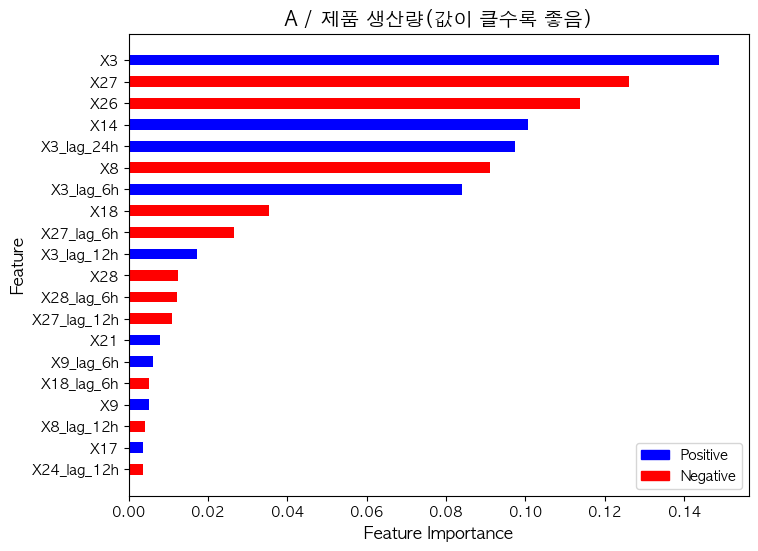

Max Depth: 3
Number of Estimators: 100
Learning Rate: 0.1
---------------------------------------
r2 score = 0.9291706576422758
---------------------------------------
        Feature  Importance Influence
0            X3    0.148749         P
1           X27    0.126039         N
2           X26    0.113622         N
3           X14    0.100522         P
4    X3_lag_24h    0.097384         P
5            X8    0.090960         N
6     X3_lag_6h    0.084067         P
7           X18    0.035263         N
8    X27_lag_6h    0.026674         N
9    X3_lag_12h    0.017292         P
10          X28    0.012372         N
11   X28_lag_6h    0.012329         N
12  X27_lag_12h    0.010987         N
13          X21    0.007941         P
14    X9_lag_6h    0.006174         P
15   X18_lag_6h    0.005256         N
16           X9    0.005210         P
17   X8_lag_12h    0.004163         N
18          X17    0.003758         P
19  X24_lag_12h    0.003576         N
----------------------------------

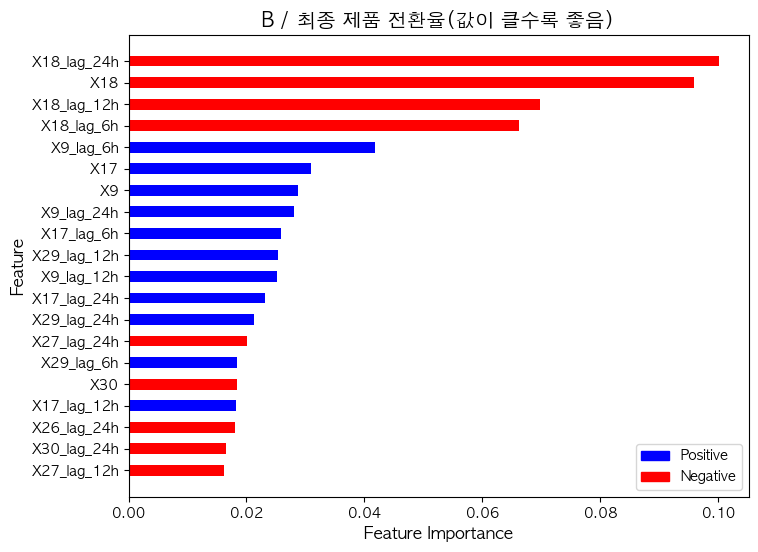

Max Depth: 3
Number of Estimators: 100
Learning Rate: 0.05
---------------------------------------
r2 score = 0.7318868439496091
---------------------------------------
        Feature  Importance Influence
0   X18_lag_24h    0.100109         N
1           X18    0.095897         N
2   X18_lag_12h    0.069740         N
3    X18_lag_6h    0.066262         N
4     X9_lag_6h    0.041769         P
5           X17    0.031012         P
6            X9    0.028709         P
7    X9_lag_24h    0.028087         P
8    X17_lag_6h    0.025878         P
9   X29_lag_12h    0.025348         P
10   X9_lag_12h    0.025089         P
11  X17_lag_24h    0.023136         P
12  X29_lag_24h    0.021244         P
13  X27_lag_24h    0.020163         N
14   X29_lag_6h    0.018384         P
15          X30    0.018332         N
16  X17_lag_12h    0.018275         P
17  X26_lag_24h    0.018016         N
18  X30_lag_24h    0.016462         N
19  X27_lag_12h    0.016265         N
---------------------------------

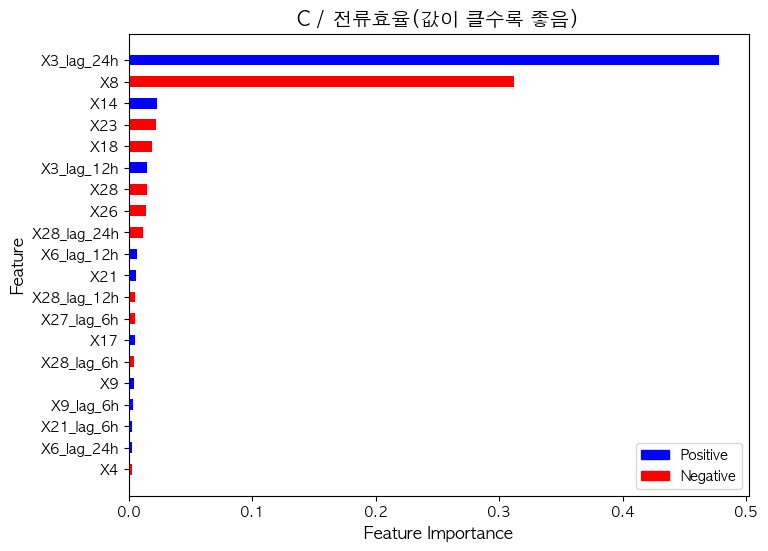

Max Depth: 3
Number of Estimators: 100
Learning Rate: 0.1
---------------------------------------
r2 score = 0.9810814448387343
---------------------------------------
        Feature  Importance Influence
0    X3_lag_24h    0.477878         P
1            X8    0.311739         N
2           X14    0.023302         P
3           X23    0.021904         N
4           X18    0.019206         N
5    X3_lag_12h    0.015334         P
6           X28    0.015090         N
7           X26    0.013920         N
8   X28_lag_24h    0.011669         N
9    X6_lag_12h    0.007001         P
10          X21    0.006433         P
11  X28_lag_12h    0.005194         N
12   X27_lag_6h    0.005121         N
13          X17    0.004848         P
14   X28_lag_6h    0.004808         N
15           X9    0.004074         P
16    X9_lag_6h    0.003609         P
17   X21_lag_6h    0.002754         P
18   X6_lag_24h    0.002524         P
19           X4    0.002480         N
----------------------------------

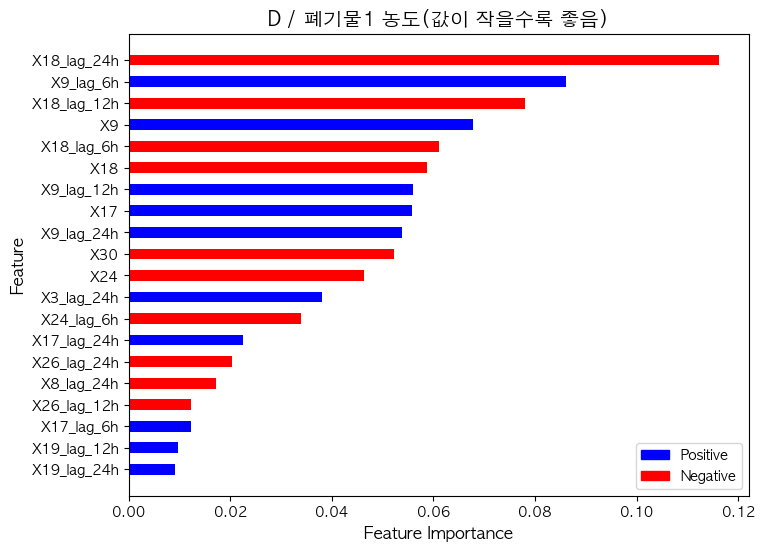

Max Depth: 3
Number of Estimators: 100
Learning Rate: 0.1
---------------------------------------
r2 score = 0.9734793276410015
---------------------------------------
        Feature  Importance Influence
0   X18_lag_24h    0.116215         N
1     X9_lag_6h    0.086005         P
2   X18_lag_12h    0.077972         N
3            X9    0.067816         P
4    X18_lag_6h    0.061123         N
5           X18    0.058709         N
6    X9_lag_12h    0.056005         P
7           X17    0.055882         P
8    X9_lag_24h    0.053794         P
9           X30    0.052163         N
10          X24    0.046436         N
11   X3_lag_24h    0.038125         P
12   X24_lag_6h    0.033919         N
13  X17_lag_24h    0.022621         P
14  X26_lag_24h    0.020375         N
15   X8_lag_24h    0.017307         N
16  X26_lag_12h    0.012272         N
17   X17_lag_6h    0.012261         P
18  X19_lag_12h    0.009770         P
19  X19_lag_24h    0.009213         P
----------------------------------

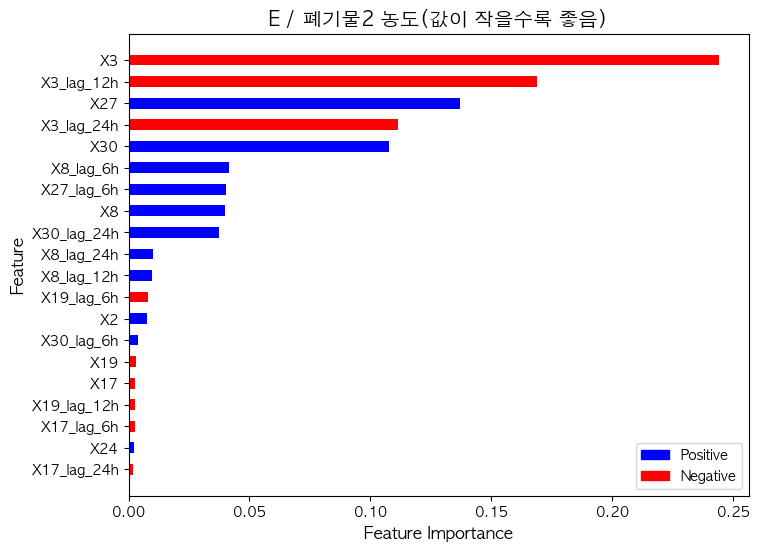

Max Depth: 7
Number of Estimators: 200
Learning Rate: 0.1
---------------------------------------
r2 score = 0.9990999603371027
---------------------------------------
        Feature  Importance Influence
0            X3    0.244063         N
1    X3_lag_12h    0.168954         N
2           X27    0.137026         P
3    X3_lag_24h    0.111210         N
4           X30    0.107763         P
5     X8_lag_6h    0.041559         P
6    X27_lag_6h    0.040170         P
7            X8    0.039924         P
8   X30_lag_24h    0.037274         P
9    X8_lag_24h    0.010210         P
10   X8_lag_12h    0.009836         P
11   X19_lag_6h    0.007860         N
12           X2    0.007637         P
13   X30_lag_6h    0.003973         P
14          X19    0.003175         N
15          X17    0.002770         N
16  X19_lag_12h    0.002701         N
17   X17_lag_6h    0.002654         N
18          X24    0.002124         P
19  X17_lag_24h    0.001989         N
----------------------------------

In [28]:
for var in var_list:
    result(var)

- 학습 결과, 각 관리 변수 별로 다른 파라미터가 사용되었습니다.

- B의 r2 socre만 상대적으로 낮은 값이 나왔습니다.
  
- 각 관리 변수 별로 조업 변수들과 시간 지연 정도가 다양한 분포를 나타냅니다. 이는 관리 변수 별로 다른 공정 제어가 필요함을 의미합니다.
  
- 여러 변수들의 중요도가 고르게 분포된 관리 변수도 있는 반면, 특정 변수에 치우처진 경우도 존재합니다.

### 결과 및 기대효과

1. 각 관리 변수에 영향도가 큰 조업 변수 및 시간 지연 정도를 확인할 수 있습니다.

2. 각 관리 변수에 대한 조업 변수의 긍정/부정 여부 또한 파악할 수 있습니다. (ABC는 상승하는 방향, DE는 하락하는 방향)

3. 관리 변수의 표준편차 정도를 통해 각 관리 변수 별로 가중치를 부여하여 공정의 효율성을 높일 수 있습니다.

- 이를 통하여, 각 관리 변수 별로 조업 변수의 영향 정도를 파악하여, 각 공정 조건을 조정하거나 제어하여 해당 관리 변수틀 통한 생산 효율성을 높일 수 있습니다. 

- 또한, 날짜와 시간에서 추출한 특징들은 전기 분해 공정의 효율성을 시간적 관점에서 이해하는 데 도움이 될 수 있습니다.

### 결과 고찰
- 변수의 숫자가 굉장히 많았기에 이 중에서 중요 특징들을 추출하는 과정이 쉽지 않았습니다.

- 각각의 조업 변수가 어떤 값을 의미하는지 알지 못하기에 순전히 상관관계에 의존하여 EDA 과정을 진행해야 했습니다.

- 상관관계 분석은 공정의 중요한 요소를 이해하는 데 중요한 역할을 하지만, 상관관계가 인과관계를 의미하지는 않으므로, 모델링에서 추가적인 검증과 분석이 필요합니다.

- 시간 관련 특징들의 분석은 공정의 시간적 변동성을 이해하고, 이를 통해 공정을 최적화할 수 있는 인사이트를 제공합니다. 이는 공정 스케줄링, 유지 보수 계획 및 에너지 사용 최적화에 중요한 영향을 미칠 수 있습니다.

##### 추가 보완점

다중공성선 해결 과정에서 기준을 명확히 잡지 못한 것 같습니다.\
주성분 분석(PCA)을 통해 추가 검토 예정입니다.